In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv("Nat_Gas.csv")

In [3]:
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 648.0+ bytes


In [5]:
df.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [6]:
#to fromat the dates in mm/dd/yyyy format for the pandas to understand
df['Dates'] = pd.to_datetime(df['Dates'],format='%m/%d/%y')

In [7]:
#sort dates ascending and set index
df= df.sort_values('Dates')
df.set_index('Dates', inplace= True)

In [8]:
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


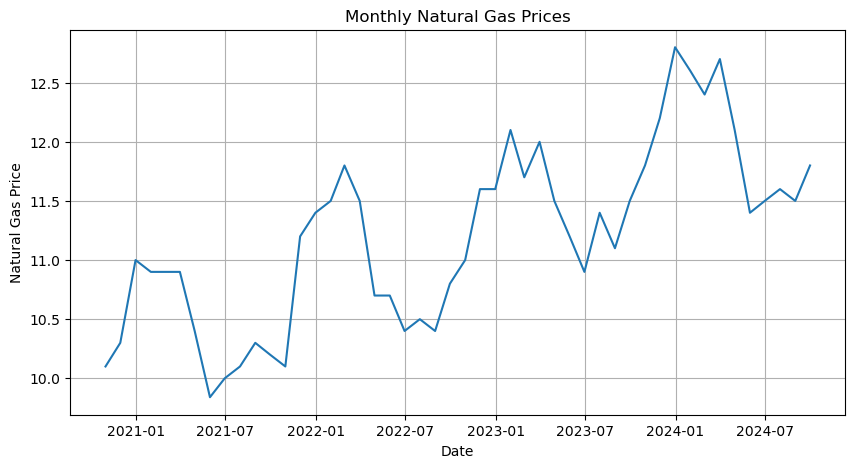

In [9]:
#plot date vs price to check seasonal trend
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Prices'])
plt.xlabel('Date')
plt.ylabel('Natural Gas Price')
plt.title('Monthly Natural Gas Prices')
plt.grid(True)
plt.show()

In [32]:
#break the dates to extract month and find average monthly prices
df['Month']= df.index.month
monthly_avg = df.groupby('Month')['Prices'].mean()
monthly_avg

Month
1     11.775
2     11.700
3     11.775
4     11.175
5     10.785
6     10.700
7     10.900
8     10.825
9     11.075
10    10.750
11    11.325
12    11.700
Name: Prices, dtype: float64

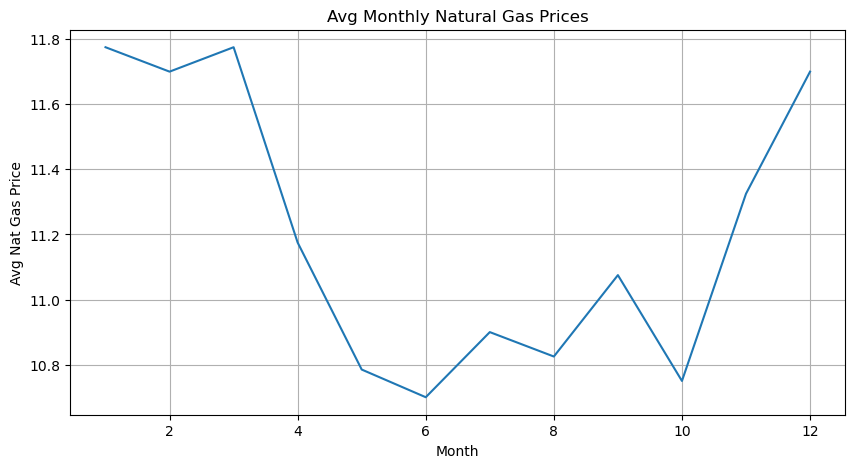

In [17]:
#plot a monthly trend for average prices
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg)
plt.xlabel('Month')
plt.ylabel('Avg Nat Gas Price')
plt.title('Avg Monthly Natural Gas Prices')
plt.grid(True)
plt.show()

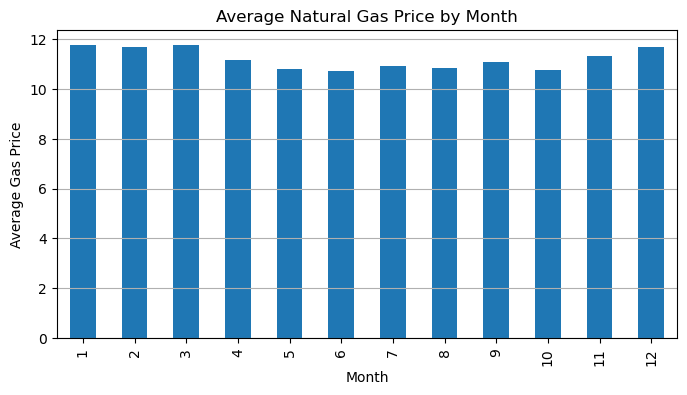

In [18]:
#histogram per month average price
plt.figure(figsize=(8, 4))
monthly_avg.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Gas Price')
plt.title('Average Natural Gas Price by Month')
plt.grid(axis='y')
plt.show()


In [23]:
#prices to any date - we create a date range followed by the logic to liner interpolate the price
daily_index = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq='D'
)
df_daily = df.reindex(daily_index)
df_daily['Prices'] = df_daily['Prices'].interpolate(method='time')
df_daily.head(10)

,Prices,Month
2020-10-31,10.100000,10.0
2020-11-01,10.106667,NaN
2020-11-02,10.113333,NaN
2020-11-03,10.120000,NaN
2020-11-04,10.126667,NaN
2020-11-05,10.133333,NaN
2020-11-06,10.140000,NaN
2020-11-07,10.146667,NaN
2020-11-08,10.153333,NaN
2020-11-09,10.160000,NaN


In [24]:
#verify price for a random date
df_daily.loc['2021-03-15']

Prices    10.9
Month      NaN
Name: 2021-03-15 00:00:00, dtype: float64

In [29]:
#calculate monthly seasonality factor - average monthly prices / average of average monthly prices
df_monthly = df.copy()
df_monthly['Month'] = df_monthly.index.month
df_monthly.head()
seasonal_factor = (df_monthly.groupby('Month')['Prices'].mean()/ df_monthly['Prices'].mean())
seasonal_factor

Month
1     1.050675
2     1.043983
3     1.050675
4     0.997137
5     0.962338
6     0.954753
7     0.972599
8     0.965907
9     0.988214
10    0.959215
11    1.010522
12    1.043983
Name: Prices, dtype: float64

In [41]:
#future dates for next 1 year
future_dates = pd.date_range(
    start=df.index.max() + pd.offsets.MonthEnd(1),
    periods=12,
    freq='ME'
)
future_dates

DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', freq='ME')

In [42]:
#estimate future prices based on extrapolation
base_price = df['Prices'].iloc[-12:].mean()

future_prices = [
base_price * seasonal_factor[date.month]
    for date in future_dates
]

future_df = pd.DataFrame(
    {'Prices': future_prices},
    index=future_dates
)
future_df


,Prices
2024-10-31,11.542551
2024-11-30,12.159943
2024-12-31,12.562591
2025-01-31,12.643120
2025-02-28,12.562591
2025-03-31,12.643120
2025-04-30,11.998885
2025-05-31,11.580132
2025-06-30,11.488865
2025-07-31,11.703610


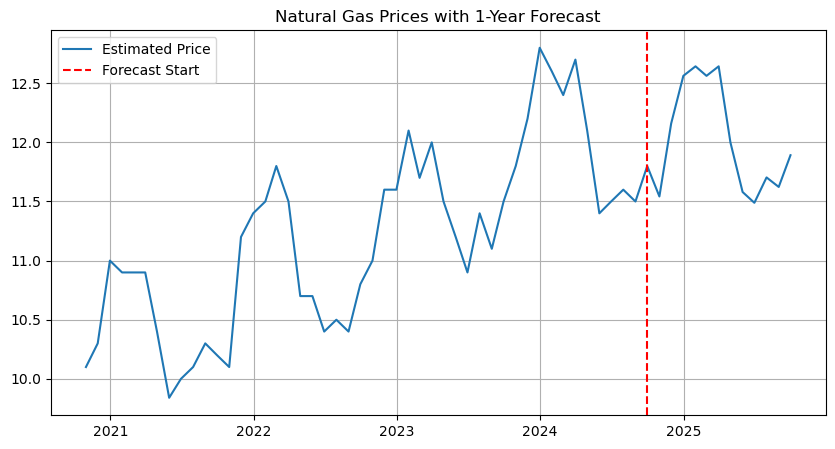

In [43]:
#combined historiacal and future data
combined_df = pd.concat([df[['Prices']], future_df])

plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['Prices'], label='Estimated Price')
plt.axvline(df.index.max(), color='red', linestyle='--', label='Forecast Start')
plt.legend()
plt.title('Natural Gas Prices with 1-Year Forecast')
plt.grid(True)
plt.show()


In [44]:
#finally function to take input as date and provide the price based on the date
def estimate_gas_price(date_str):
    date = pd.to_datetime(date_str)

    if date <= df_daily.index.max():
        return float(df_daily.loc[date]['Prices'])

    elif date <= combined_df.index.max():
        return float(combined_df.loc[combined_df.index >= date]['Prices'].iloc[0])

    else:
        raise ValueError("Date is beyond supported forecast range")


In [48]:
#test function 'estimate_gas_price'
estimate_gas_price('2024-12-27')

12.562590623489609

In [49]:
estimate_gas_price('2026-12-27')

<class 'ValueError'>: Date is beyond supported forecast range

In [50]:
estimate_gas_price('2025-07-27')

11.70361006803733